In [515]:
import numpy as np
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt

path = '/kaggle/input/data/'

bbox_csv = 'BBox_List_2017.csv'
data_csv = 'Data_Entry_2017.csv'

imgs_folders = ['images_001', 'images_002', 'images_003',
       'images_004', 'images_005', 'images_006', 'images_007',
       'images_008', 'images_009', 'images_010', 'images_011',
       'images_012']

Categories = ['Atelectasis', 'Cardiomegaly', 'Consolidation',
        'Edema', 'Effusion', 'Fibrosis', 'Infiltration', 'Mass',
        'Pneumothorax', 'Emphysema', 'Pneumonia', 'Pleural_Thickening',
        'Nodule', 'Hernia', 'No Finding']

data_df = pd.read_csv(path + data_csv)
box_df  = pd.read_csv(path + bbox_csv)

In [492]:
box_df[box_df['Image Index']=='00000032_037.png']

,Image Index,Finding Label,Bbox [x,y,w,h],Unnamed: 6,Unnamed: 7,Unnamed: 8
547,00000032_037.png,Infiltrate,339.166138,119.195767,172.292063,351.085714,NaN,NaN,NaN


In [523]:
def Adjust_data(data, box):
    data = data[['Image Index', 'Finding Labels']]
    box = Adjust_box(box)
    new_data = pd.merge(left=data, right=box, left_on ='Image Index', right_on ='Image Index', how = 'left')
    new_data = new_data.rename(columns={'Finding Labels': 'All Labels', 'Finding Label' : "Det Label"})
    new_data = new_data.fillna({'Det Label': 'No Finding', 'Bbox':0})
    
    return new_data ,box  

def Adjust_box(box_df):
    box_df['Finding Label'] = box_df['Finding Label'].str.replace('Infiltrate','Infiltration')
    
    #Sorting by Image index (not needed but helps in debugging)
    box_df['sort'] = box_df['Image Index'].str.extract('(\d+)', expand=False).astype(int)
    box_df.sort_values('sort',inplace=True, ascending=True)
    box_df = box_df.reset_index(drop=True)
    box_df = box_df.drop(['sort','Unnamed: 6','Unnamed: 7','Unnamed: 8'], axis=1)
    
    #Getting all values of x, y ,w ,h
    x= box_df.groupby('Image Index')['Bbox [x'].apply(np.array).reset_index()['Bbox [x'].values
    y= box_df.groupby('Image Index')['y'].apply(np.array).reset_index()['y'].values
    w= box_df.groupby('Image Index')['w'].apply(np.array).reset_index()['w'].values
    h= box_df.groupby('Image Index')['h]'].apply(np.array).reset_index()['h]'].values
    box_df= box_df.groupby('Image Index')['Finding Label'].apply('|'.join).reset_index()
    
    #Arranging the bounding boxes values into arrays
    bbox1 = []
    for i in range(len(x)):
        bbox2 = []
        for a,b,c,d in zip(x[i], y[i], w[i], h[i]):
            bbox2.append(np.array([a, b, c, d]))
        bbox1.append(bbox2)
        
    #Concatenating the bounding boxes into 1 line of string format
    mbbs = [' '.join(str(x) for p in o for x in p) for o in bbox1]
    
    box_df["Bbox"] = mbbs
    return box_df

def dfcat2dfid(df, Categories): # change dataframe of category names into category numbers
    cat2id = {i:j for j,i in enumerate(Categories)}
    id2cat = {i:j for i,j in enumerate(Categories)}

    All_Cat = df['All Labels'].values.astype(str)
    All_cat_list = [i.split('|') for i in All_Cat]

    Det = df['Det Label'].values.astype(str)
    Det_list = [i.split('|') for i in Det]


    mcs_All_Labels = np.array([np.array([cat2id[p] for p in o]) for o in All_cat_list])
    mcs_Det_Labels = np.array([np.array([cat2id[p] for p in o]) for o in Det_list])

    df['Class_All'] = mcs_All_Labels
    df['Class_Det'] = mcs_Det_Labels
    
    return df

In [516]:
df, Xbox = Adjust_data(data_df, box_df)
df.head()

,Image Index,All Labels,Det Label,Bbox
0,00000001_000.png,Cardiomegaly,No Finding,0
1,00000001_001.png,Cardiomegaly|Emphysema,No Finding,0
2,00000001_002.png,Cardiomegaly|Effusion,No Finding,0
3,00000002_000.png,No Finding,No Finding,0
4,00000003_000.png,Hernia,No Finding,0


In [517]:
bad_det= '00000032_037.png'
good_det = '00005066_030.png'

print('Value = ', Xbox[Xbox['Image Index']== bad_det]['Bbox'].values)
Xbox[Xbox['Image Index']== bad_det].head()

Value =  ['339.166137566138 119.195767195767 172.29206349206402 351.08571428571406']


,Image Index,Finding Label,Bbox
0,00000032_037.png,Infiltration,339.166137566138 119.195767195767 172.29206349...


In [518]:
#Has more labels classified but only infiltration is detected
print('Value = ', df[df['Image Index']== bad_det]['Bbox'].values)
df[df['Image Index']== bad_det].head()

Value =  ['339.166137566138 119.195767195767 172.29206349206402 351.08571428571406']


,Image Index,All Labels,Det Label,Bbox
151,00000032_037.png,Cardiomegaly|Edema|Infiltration,Infiltration,339.166137566138 119.195767195767 172.29206349...


In [519]:
print('Value = ', Xbox[Xbox['Image Index']== good_det]['Bbox'].values)
Xbox[Xbox['Image Index']== good_det].head()

Value =  ['531.911111111111 499.80682291666704 242.34666666666698 163.84 277.152542372881 459.15480998410993 540.2033898305091 301.559322033898 149.617777777778 728.50015625 27.306666666666697 65.9911111111111']


,Image Index,Finding Label,Bbox
113,00005066_030.png,Infiltration|Cardiomegaly|Effusion,531.911111111111 499.80682291666704 242.346666...


In [520]:
#Has labels classified same as detected
print('Value = ', df[df['Image Index']== good_det]['Bbox'].values)
df[df['Image Index']== good_det].head()

Value =  ['531.911111111111 499.80682291666704 242.34666666666698 163.84 277.152542372881 459.15480998410993 540.2033898305091 301.559322033898 149.617777777778 728.50015625 27.306666666666697 65.9911111111111']


,Image Index,All Labels,Det Label,Bbox
19034,00005066_030.png,Cardiomegaly|Effusion|Infiltration,Infiltration|Cardiomegaly|Effusion,531.911111111111 499.80682291666704 242.346666...


In [522]:
df.head()

,Image Index,All Labels,Det Label,Bbox
0,00000001_000.png,Cardiomegaly,No Finding,0
1,00000001_001.png,Cardiomegaly|Emphysema,No Finding,0
2,00000001_002.png,Cardiomegaly|Effusion,No Finding,0
3,00000002_000.png,No Finding,No Finding,0
4,00000003_000.png,Hernia,No Finding,0


In [526]:
df = dfcat2dfid(df, Categories)

df.head()

,Image Index,All Labels,Det Label,Bbox,Class_All,Class_Det
0,00000001_000.png,Cardiomegaly,No Finding,0,[1],[14]
1,00000001_001.png,Cardiomegaly|Emphysema,No Finding,0,"[1, 9]",[14]
2,00000001_002.png,Cardiomegaly|Effusion,No Finding,0,"[1, 4]",[14]
3,00000002_000.png,No Finding,No Finding,0,[14],[14]
4,00000003_000.png,Hernia,No Finding,0,[13],[14]


In [531]:
print('Bbox = ', df[df['Image Index']==good_det]['Bbox'].values)
df[df['Image Index']==good_det].head()

Bbox =  531.911111111111 499.80682291666704 242.34666666666698 163.84 277.152542372881 459.15480998410993 540.2033898305091 301.559322033898 149.617777777778 728.50015625 27.306666666666697 65.9911111111111


,Image Index,All Labels,Det Label,Bbox,Class_All,Class_Det
19034,00005066_030.png,Cardiomegaly|Effusion|Infiltration,Infiltration|Cardiomegaly|Effusion,531.911111111111 499.80682291666704 242.346666...,"[1, 4, 6]","[6, 1, 4]"


In [530]:
np.asmatrix(df[df['Image Index']==good_det]['Bbox'].values[0])

matrix([[531.91111111, 499.80682292, 242.34666667, 163.84      ,
         277.15254237, 459.15480998, 540.20338983, 301.55932203,
         149.61777778, 728.50015625,  27.30666667,  65.99111111]])

In [499]:
cat2id = {i:j for j,i in enumerate(Categories)}
id2cat = {i:j for i,j in enumerate(Categories)}

cat2id

{'Atelectasis': 0,
 'Cardiomegaly': 1,
 'Consolidation': 2,
 'Edema': 3,
 'Effusion': 4,
 'Fibrosis': 5,
 'Infiltration': 6,
 'Mass': 7,
 'Pneumothorax': 8,
 'Emphysema': 9,
 'Pneumonia': 10,
 'Pleural_Thickening': 11,
 'Nodule': 12,
 'Hernia': 13,
 'No Finding': 14}

In [500]:
All_Cat = df['All Labels'].values.astype(str)
All_cat_list = [i.split('|') for i in All_Cat]

All_cat_list[40:50]

[['Emphysema', 'Pneumothorax'],
 ['Pleural_Thickening'],
 ['Effusion', 'Emphysema', 'Infiltration', 'Pneumothorax'],
 ['Emphysema', 'Infiltration', 'Pleural_Thickening', 'Pneumothorax'],
 ['Effusion', 'Infiltration'],
 ['Infiltration'],
 ['No Finding'],
 ['Pleural_Thickening'],
 ['Effusion', 'Pneumonia', 'Pneumothorax'],
 ['Pneumothorax']]

In [501]:
mcs_All_Labels = np.array([np.array([cat2id[p] for p in o]) for o in All_cat_list])
mcs_All_Labels[40:50]

array([array([9, 8]), array([11]), array([4, 9, 6, 8]),
       array([ 9,  6, 11,  8]), array([4, 6]), array([6]), array([14]),
       array([11]), array([ 4, 10,  8]), array([8])], dtype=object)

In [502]:
Det = df['Det Label'].values.astype(str)
Det_list = [i.split('|') for i in Det]

In [503]:
Det_list[19034]

['Infiltration', 'Cardiomegaly', 'Effusion']

In [504]:
Det_list[19000 : 19035]

[['No Finding'],
 ['No Finding'],
 ['No Finding'],
 ['No Finding'],
 ['No Finding'],
 ['No Finding'],
 ['No Finding'],
 ['No Finding'],
 ['No Finding'],
 ['Cardiomegaly'],
 ['No Finding'],
 ['No Finding'],
 ['No Finding'],
 ['No Finding'],
 ['No Finding'],
 ['No Finding'],
 ['No Finding'],
 ['No Finding'],
 ['No Finding'],
 ['No Finding'],
 ['No Finding'],
 ['No Finding'],
 ['No Finding'],
 ['No Finding'],
 ['No Finding'],
 ['No Finding'],
 ['No Finding'],
 ['No Finding'],
 ['No Finding'],
 ['No Finding'],
 ['No Finding'],
 ['No Finding'],
 ['No Finding'],
 ['No Finding'],
 ['Infiltration', 'Cardiomegaly', 'Effusion']]

In [506]:
mcs_Det_Labels = np.array([np.array([cat2id[p] for p in o]) for o in Det_list])

mcs_Det_Labels[19000 : 19035]

array([array([14]), array([14]), array([14]), array([14]), array([14]),
       array([14]), array([14]), array([14]), array([14]), array([1]),
       array([14]), array([14]), array([14]), array([14]), array([14]),
       array([14]), array([14]), array([14]), array([14]), array([14]),
       array([14]), array([14]), array([14]), array([14]), array([14]),
       array([14]), array([14]), array([14]), array([14]), array([14]),
       array([14]), array([14]), array([14]), array([14]),
       array([6, 1, 4])], dtype=object)

In [323]:
x= box_df.groupby('Image Index')['Bbox [x'].apply(np.array).reset_index()['Bbox [x'].values
y= box_df.groupby('Image Index')['y'].apply(np.array).reset_index()['y'].values
w= box_df.groupby('Image Index')['w'].apply(np.array).reset_index()['w'].values
h= box_df.groupby('Image Index')['h]'].apply(np.array).reset_index()['h]'].values
box_df= box_df.groupby('Image Index')['Finding Label'].apply('|'.join).reset_index()

In [333]:
box_df[box_df['Image Index'] == '00005066_030.png']

,Image Index,Finding Label
113,00005066_030.png,Infiltrate|Cardiomegaly|Effusion


In [352]:
bbox1 = []
for i in range(len(x)):
    bbox2 = []
    for a,b,c,d in zip(x[i], y[i], w[i], h[i]):
        bbox2.append(np.array([a, b, c, d]))
    bbox1.append(bbox2)

In [373]:
box_df[10:30]

,Image Index,Finding Label
10,00000211_041.png,Cardiomegaly
11,00000344_003.png,Effusion
12,00000377_004.png,Cardiomegaly
13,00000398_003.png,Cardiomegaly
14,00000457_004.png,Atelectasis
15,00000468_017.png,Atelectasis
16,00000468_033.png,Atelectasis
17,00000468_041.png,Infiltrate
18,00000506_013.png,Pneumonia
19,00000583_008.png,Atelectasis


In [374]:
box[box["Image Index"]== '00000732_005.png']

,Image Index,Finding Label,Bbox [x,y,w,h]
22,00000732_005.png,Pneumothorax,613.831111,110.686823,172.942222,103.537778
23,00000732_005.png,Cardiomegaly,427.932203,464.000000,412.203390,344.949153


In [376]:
mbbs = [' '.join(str(x) for p in o for x in p) for o in bbox1]

In [380]:
box_df["Bbox"] = mbbs
box_df

,Image Index,Finding Label,Bbox
0,00000032_037.png,Infiltrate,339.166137566138 119.195767195767 172.29206349...
1,00000072_000.png,Atelectasis,356.503703703704 567.805291005291 127.86455026...
2,00000147_001.png,Atelectasis,617.650793650794 599.2296296296299 100.7746031...
3,00000149_006.png,Atelectasis,603.661016949153 460.23955574682196 249.491525...
4,00000150_002.png,Pneumonia,601.3968253968251 595.978835978836 215.6359788...
...,...,...,...
875,00030606_006.png,Pneumothorax,550.467724867725 31.424338624338603 236.224338...
876,00030634_000.png,Effusion,141.653333333333 611.309045138889 317.44 96.71...
877,00030635_001.png,Atelectasis,576.542372881356 490.612437102754 240.81355932...
878,00030636_004.png,Infiltrate|Atelectasis,612.6933333333329 459.984600694444 224.1422222...


In [3]:
img1_path = path+imgs_folders[0]+'/images/'
img1 = os.listdir(img1_path)

In [4]:
s_img = cv2.imread(img1_path+img1[2])

In [5]:
s_img.shape

(1024, 1024, 3)

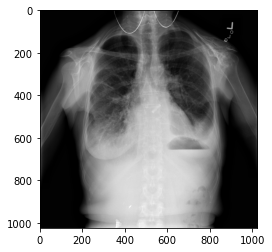

In [6]:
plt.imshow(s_img, cmap= plt.cm.bone)

In [8]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input

In [ ]:
class Data_gen(keras.utils.Sequence):
    'Generates data from a Dataframe'
    def __init__(self, df, folder,preprocess_fct,batch_size=32, dim=(256,256), shuffle=True):
        'Initialization'
        self.preprocess_fct = preprocess_fct
        self.dim = dim
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.folder = folder

        self.df = df
        self.n = len(df)            
        self.nb_iteration = int(np.floor(self.n  / self.batch_size))
        
        self.on_epoch_end()
                    
    def __len__(self):
        'Denotes the number of batches per epoch'
        return self.nb_iteration

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        X, y = self.__data_generation(indexes)

        return X, y
   
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, index):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        nb_label_max = 20
        X = np.empty((self.batch_size, *self.dim, 3))
        Y = []
        
        # Generate data
        for i, ID in enumerate(index):
            # Read the image
            img = Image.open(self.folder/self.df['filename'][ID])
            
            # extract the number of label
            c = self.df['class'][ID]
            nb_label = len(c)            
            
            # Class in a form of a one hot encoding
            y = np.zeros((nb_label_max,1+4));
            y[:nb_label,0] = c
            
            # reshape the bounding box and resize
            bbox = np.asmatrix(self.df['bbox'][ID])
            bbox = bbox.reshape(nb_label,4)
            
            bbox_rescaled = np.copy(bbox)    
            bbox_rescaled = bbox_rescaled.astype(float)
            width, height = img.size
            RatioX = width/self.dim[0]
            RatioY = height/self.dim[1]

            bbox_rescaled[:,0] = bbox_rescaled[:,0]/RatioY/self.dim[1]
            bbox_rescaled[:,1] = bbox_rescaled[:,1]/RatioX/self.dim[0]
            bbox_rescaled[:,2] = bbox_rescaled[:,2]/RatioY/self.dim[1]
            bbox_rescaled[:,3] = bbox_rescaled[:,3]/RatioX/self.dim[0]        
        
            # save the bb coordinates
            y[:nb_label,1:5] = bbox_rescaled
            
       
            # reshape to a vector
            y=np.reshape(y,nb_label_max*5)
                                                                    
            img = np.asarray(img.resize(self.dim))
            X[i,] = self.preprocess_fct(np.asarray(img))
            
            Y.append(np.asarray(y))

        Y = np.asarray(Y)
        
        return X, Y 